In [51]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers.core import Dense, Dropout, Activation 
from keras.layers.embeddings import Embedding 
from keras.layers.recurrent import LSTM 
import sklearn
from sklearn.model_selection import train_test_split
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score,accuracy_score, classification_report,precision_score
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

In [61]:
## Read the data
df = pd.read_csv("./data/dga-dataset.txt",
                 names=['Domain','Origin','Class'], sep='\x01')
#df['Class'] = df['Class'].dropna(inplace=True) 

df = df.replace('legit',0)
df = df.replace('LEGIT',0)
df = df.replace('lgit',0) 
df = df.replace('lefit',0) 
df = df.replace('legip',0)
df = df.replace('leNit',0)
df = df.replace('dga',1)
df = df.replace('DGA',1)
df = df.replace('dg',1)
df = df.replace('da',1)
df = df.replace('dgb',1)
df = df.replace('dgf',1)
df = df.replace('dgS',1) 
df = df.replace('dha',1) 

nan_rows = df[df['Class'].isnull()].index
i = list(nan_rows)
df = df.drop(df.index[i])
df = df.reset_index(drop=True)

df.head()

,Domain,Origin,Class
0,bmskafjfoenhf.ru,cryptolocker,1.0
1,hollywoodreporter.com,NaN,0.0
2,wikiseda.com,NaN,0.0
3,ns1.experience.com,NaN,0.0
4,lockheedmartin.com,NaN,0.0


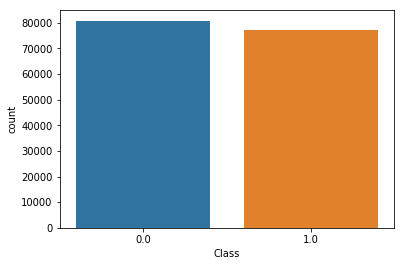

In [45]:
## Plot the distribution of data for undersampling
%matplotlib inline
sns.countplot(x='Class', data=df)

In [62]:
import tldextract
def getTopLevel(): 
    res = [] 
    for i in range(0,len(df)):
        t = tldextract.extract(df['Domain'][i])
        res.append(t.domain)
    df['Domain'] = res
    return 
getTopLevel()

In [63]:
df = df.drop(['Origin'], axis = 1)

pandas_profiling.ProfileReport(df)

Number of variables,2
Number of observations,157926
Total Missing (%),0.0%
Total size in memory,2.4 MiB
Average record size in memory,16.0 B
Numeric,0
Categorical,1
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [43]:

def build_model(max_features, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop')

    return model

def run(max_epoch=25, nfolds=10, batch_size=128):
    """Run train/test on logistic regression model"""
    indata = df

    # Extract data and labels
    X = list(df['Domain'])
    labels = list(df['Class'])

    # Generate a dictionary of valid characters
    valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}

    max_features = len(valid_chars) + 1
    maxlen = np.max([len(x) for x in X])

    # Convert characters to int and pad
    X = [[valid_chars[y] for y in x] for x in X]
    X = sequence.pad_sequences(X, maxlen=maxlen)

    # Convert labels to 0-1
    y = list(df['Class'])

    final_data = []

    for fold in range(nfolds):
        print("fold %u/%u" % (fold+1, nfolds))
        X_train, X_test, y_train, y_test, _, label_test = train_test_split(X, y, labels, 
                                                                           test_size=0.2)

        print('Build model...')
        model = build_model(max_features, maxlen)

        print("Train...")
        X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.05)
        best_iter = -1
        best_auc = 0.0
        out_data = {}

        for ep in range(max_epoch):
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1)

            t_probs = model.predict_proba(X_holdout)
            t_auc = sklearn.metrics.roc_auc_score(y_holdout, t_probs)

            print('Epoch %d: auc = %f (best=%f)' % (ep, t_auc, best_auc))

            if t_auc > best_auc:
                best_auc = t_auc
                best_iter = ep

                probs = model.predict_proba(X_test)

                out_data = {'y':y_test, 'labels': label_test, 'probs':probs, 'epochs': ep,
                            'confusion_matrix': sklearn.metrics.confusion_matrix(y_test, probs > .5)}

                print(sklearn.metrics.confusion_matrix(y_test, probs > .5))
            else:
                # No longer improving...break and calc statistics
                if (ep-best_iter) > 2:
                    break

        final_data.append(out_data)

    return model


In [7]:
dgab = run(max_epoch=1, nfolds=1, batch_size=128)

fold 1/1
Build model...
Train...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
120023/120023 [==============================] - 97s 810us/step - loss: 0.1292
Epoch 0: auc = 0.995523 (best=0.000000)
[[15555   531]
 [  488 15012]]


In [48]:
y = list(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.90, random_state = 0)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.95')

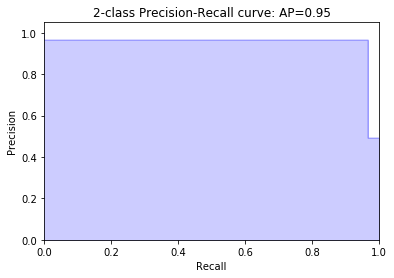

In [46]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

ypred = dgab.predict_classes(X_test)
ypred = list(np.concatenate(ypred))

average_precision_under = average_precision_score(y_test,ypred)

precision, recall, _ = precision_recall_curve(y_test,ypred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_under))

In [64]:
X = list(df['Domain'])

# Generate a dictionary of valid characters
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}
maxlen = np.max([len(x) for x in X])

# Convert characters to int and pad
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

y = list(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.90, random_state = 0)

ypred = dgab.predict_classes(X_test)

print(accuracy_score(y_test,ypred))
print(recall_score(y_test,ypred))
print(precision_score(y_test,ypred))

0.9676572811572178
0.9688376306820633
0.9651872439185124
